In [1]:
!pip install torchaudio datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 5.2 MB/s 
     |████████████████████████████████| 212 kB 51.5 MB/s 
     |████████████████████████████████| 163 kB 44.9 MB/s 
     |████████████████████████████████| 115 kB 54.3 MB/s 
     |████████████████████████████████| 127 kB 55.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [1]:
import torchaudio
import torch
import matplotlib.pyplot as plt
import librosa
from datasets import load_dataset
import random
import torch
import numpy as np
from specmix import specmix

In [2]:
BATCH_SIZE = 32  # Batch-size for training and evaluating our model.

In [3]:
# Datasets and preprocessing part is taken from https://keras.io/examples/audio/wav2vec2_audiocls/
speech_commands_v1 = load_dataset("superb", "ks")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:

speech_commands_v1 = speech_commands_v1["train"].train_test_split(
    train_size=0.5, test_size=0.5, stratify_by_column="label"
)

speech_commands_v1 = speech_commands_v1.filter(
    lambda x: x["label"]
    != (
        speech_commands_v1["train"].features["label"].names.index("_unknown_")
        and speech_commands_v1["train"].features["label"].names.index("_silence_")
    )
)

speech_commands_v1["train"] = speech_commands_v1["train"].select(
    [i for i in range((len(speech_commands_v1["train"]) // BATCH_SIZE) * BATCH_SIZE)]
)
speech_commands_v1["test"] = speech_commands_v1["test"].select(
    [i for i in range((len(speech_commands_v1["test"]) // BATCH_SIZE) * BATCH_SIZE)]
)

print(speech_commands_v1)


  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 25536
    })
    test: Dataset({
        features: ['file', 'audio', 'label'],
        num_rows: 25536
    })
})


In [5]:
labels = speech_commands_v1["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

print(id2label)

{'0': 'yes', '1': 'no', '2': 'up', '3': 'down', '4': 'left', '5': 'right', '6': 'on', '7': 'off', '8': 'stop', '9': 'go', '10': '_silence_', '11': '_unknown_'}


In [6]:
df = speech_commands_v1['train'].to_pandas()

In [7]:
df

,file,audio,label
0,/root/.cache/huggingface/datasets/downloads/ex...,"{'bytes': None, 'path': '/root/.cache/huggingf...",3
1,/root/.cache/huggingface/datasets/downloads/ex...,"{'bytes': None, 'path': '/root/.cache/huggingf...",11
2,/root/.cache/huggingface/datasets/downloads/ex...,"{'bytes': None, 'path': '/root/.cache/huggingf...",6
3,/root/.cache/huggingface/datasets/downloads/ex...,"{'bytes': None, 'path': '/root/.cache/huggingf...",11
4,/root/.cache/huggingface/datasets/downloads/ex...,"{'bytes': None, 'path': '/root/.cache/huggingf...",8
...,...,...,...
25531,/root/.cache/huggingface/datasets/downloads/ex...,"{'bytes': None, 'path': '/root/.cache/huggingf...",7
25532,/root/.cache/huggingface/datasets/downloads/ex...,"{'bytes': None, 'path': '/root/.cache/huggingf...",11
25533,/root/.cache/huggingface/datasets/downloads/ex...,"{'bytes': None, 'path': '/root/.cache/huggingf...",1
25534,/root/.cache/huggingface/datasets/downloads/ex...,"{'bytes': None, 'path': '/root/.cache/huggingf...",11


In [8]:
audios = []
labels = []
for i in range(100, 500, 5):
    audio, sr = torchaudio.load(df['file'][i])
    if audio.shape != (1, 16000):
        continue
    label = df['label'][i]
    audios.append(audio)
    labels.append(label)

In [9]:
audios = torch.cat(audios)

In [10]:
labels = torch.tensor(labels)

In [11]:
spec_extractor = torchaudio.transforms.Spectrogram()

In [12]:
specs = spec_extractor(audios)

In [13]:
one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=- 1) 

In [14]:
specs_original = torch.clone(specs)

In [40]:
out = specmix(specs[0:50], one_hot_labels[0:50], 0.99, 20, 30, 4, 3)

tensor([19,  2,  7, 39, 16,  0, 23, 48, 42, 46,  5, 34, 33,  6, 25, 10, 49,  3,
        35, 30, 32, 41, 37, 44, 28, 26,  1, 31,  4, 43, 21, 20, 29, 12, 11, 27,
        15, 38, 18, 45, 40, 14,  9, 17,  8, 36, 22, 47, 24, 13])


In [41]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
# https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


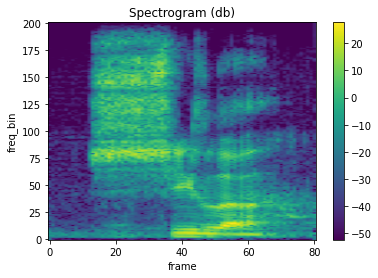

In [42]:
plot_spectrogram(specs_original[0])

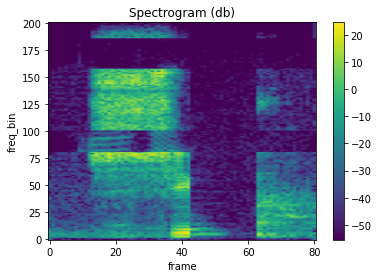

In [43]:
plot_spectrogram(out[0][0])

In [44]:
out[1][0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [45]:
labels[0]

tensor(11)

In [46]:
labels[49]

tensor(11)